In [3]:
from __future__ import print_function, division

import shutil
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn

import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
import glob
import random
from PIL import Image
from tqdm import tqdm
import argparse
from bisect import bisect_right, bisect_left

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline

plt.ion()   # interactive mode


# Import data

In [4]:
#Import csv data from folders

imu_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv')
camera_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/data.csv')
vicon_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/vicon0/data.csv')

# Drop the first row of the camera

camera_data=camera_data.drop(camera_data.index[[0]])

# re-assign name to columns

vicon_data.columns = ['timestamp','px','py','pz','qw','qx','qy','qz']
camera_data.columns = ['timestamp','filename']
imu_data.columns =['timestamp','wx','wy','wz','ax','ay','az']

# Get the timestamp of the camera and drop the index
camera_timestamps = camera_data['timestamp']
camera_timestamps = camera_timestamps.reset_index(drop=True)



In [5]:
imu_data.head()

,timestamp,wx,wy,wz,ax,ay,az
0,1413394881575760384,0.020246,0.016755,0.086568,10.149883,-0.024517,-3.203506
1,1413394881580760576,0.020944,0.038397,0.085870,8.924051,0.147100,-2.427146
2,1413394881585760512,0.009076,0.025831,0.092852,9.626861,0.171616,-2.843929
3,1413394881590760448,-0.014661,0.026529,0.093550,9.471589,0.179789,-2.745862
4,1413394881595760384,-0.017453,0.032114,0.069813,9.022118,-0.228822,-2.304563


### Interpolate Vicon data to get data at the same timestamp of the camera and IMU

In [6]:
# Vicon data

vicondata = vicon_data.copy() #create a copy

for i in range(len(camera_timestamps)):
    new_row=pd.DataFrame([[camera_timestamps[i],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]], columns = ['timestamp','px','py','pz','qw','qx','qy','qz'])
    vicondata = pd.concat([vicondata, pd.DataFrame(new_row)], ignore_index=True)
    
vicondata.sort_values(by=['timestamp'],inplace=True, ascending=True)
vicondata = vicondata.reset_index(drop = True)
vicondata = vicondata.interpolate()

   

## Create new sincronized dataframe

In [7]:

def return_idx(timestamps, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    for temp in timestamps:
        idx=int(data[data['timestamp']==temp].index[0])
        idx_sensor.append(idx)
    return idx_sensor

In [8]:
# Create a new vicon dataframe with the same timestamps of the camera

idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Create a new IMU dataframe with the same timestamps of the camera

idx_imu = return_idx(camera_timestamps, imu_data)
new_imu = imu_data.ix[idx_imu].reset_index(drop=True)
imu_timestamp = new_imu['timestamp'].values

In [9]:
# Create new dataframe for images and save it

image_data = pd.merge(camera_data,new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv(r'/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv',index = None, header=True)

In [10]:
image_data.head()

,timestamp,filename,px,py,pz,qw,qx,qy,qz
0,1413394881605760512,1413394881605760512.png,-0.964216,0.415560,1.441128,-0.029913,0.017377,0.020066,0.999200
1,1413394881655760384,1413394881655760384.png,-0.964219,0.415528,1.441112,-0.029981,0.017277,0.020207,0.999197
2,1413394881705760512,1413394881705760512.png,-0.964195,0.415586,1.441124,-0.029718,0.017409,0.020081,0.999205
3,1413394881755760384,1413394881755760384.png,-0.964204,0.415675,1.441067,-0.030195,0.017251,0.019702,0.999198
4,1413394881805760512,1413394881805760512.png,-0.964262,0.415510,1.441133,-0.029779,0.017324,0.020224,0.999202


## Get position and orientation from the IMU - to do 

In [11]:
# transform IMU data into position and orientation 
import skinematics as skin
ang_vel = new_imu[['wx','wy','wz']].values
acc = new_imu[['wx','wy','wz','ax','ay','az']].values
# init_orientation = orientation[0,:]


## Check timestamps as year-month-day and time

In [12]:
timestamp_vicon = pd.to_datetime(new_vicon[new_vicon.columns[0]], unit='ns')
timestamp_camera = pd.to_datetime(camera_data[camera_data.columns[0]], unit='ns')
timestamp_IMU = pd.to_datetime(new_imu[new_imu.columns[0]], unit='ns')
# pd.to_datetime('1413394881394290944', format='%Y%m%d', errors='ignore')

In [13]:
timestamp_vicon.head()

0   2014-10-15 17:41:21.605760512
1   2014-10-15 17:41:21.655760384
2   2014-10-15 17:41:21.705760512
3   2014-10-15 17:41:21.755760384
4   2014-10-15 17:41:21.805760512
Name: timestamp, dtype: datetime64[ns]

In [14]:
timestamp_camera.head()

1   2014-10-15 17:41:21.605760512
2   2014-10-15 17:41:21.655760384
3   2014-10-15 17:41:21.705760512
4   2014-10-15 17:41:21.755760384
5   2014-10-15 17:41:21.805760512
Name: timestamp, dtype: datetime64[ns]

In [15]:
timestamp_IMU.head()

0   2014-10-15 17:41:21.605760512
1   2014-10-15 17:41:21.655760384
2   2014-10-15 17:41:21.705760512
3   2014-10-15 17:41:21.755760384
4   2014-10-15 17:41:21.805760512
Name: timestamp, dtype: datetime64[ns]

# Import Images and split into training, validation and testing 

### Some testing

In [16]:
# Let’s read the CSV and get the filenames and labels

file = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')

img_name = file.iloc[:, 1]
labels = file.iloc[:, 2:].as_matrix()
# print('Image name: {}'.format(img_name))
# print('Labels shape: {}'.format(labels.shape))

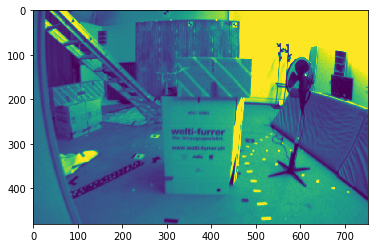

In [17]:
def show_image(image):
    """Show image """
    plt.imshow(image)
plt.figure()
show_image(io.imread(os.path.join('/home/francesca/Desktop/francesca/data/mav0/cam0/data/' + img_name[1000])))
plt.show()

## Create Customized Dataset 

In [18]:
class NewDataset(Dataset):
    """Pose dataset."""
    def __init__(self, csv_file, imu_path, root_dir):       
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.imu_data = pd.read_csv(imu_path)

        # Second - 7th columns contains the angular rate and acceleration
        self.imu_arr = self.imu_data.iloc[:, 1:].as_matrix()
        self.imu_arr = self.imu_arr.astype('float')


        # Second column contains the image name
        self.image_arr = np.asarray(self.frame.iloc[:, 1])
        self.label_arr = np.asarray(self.frame.iloc[:, 2:])
        self.root_dir = root_dir

        transformation = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
#         self.to_tensor=transforms.Compose(transform_list)
        self.transform = transformation
        # Calculate len
        self.data_len = len(self.frame.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        single_image_name = self.image_arr[idx]
        fp = self.root_dir
        # Open image
        image = Image.open(fp + single_image_name).convert('RGB')
#         image = self.to_tensor(image)
        image = self.transform(image)
    
        imu_data = self.imu_arr

        labels = self.label_arr[idx]
#         sample = {'image': image, 'labels': labels}

        return image, imu_data, labels

In [23]:
newdataset = NewDataset(csv_file='/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv', 
                         imu_path='/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv',
                           root_dir='/home/francesca/Desktop/francesca/data/mav0/cam0/data/')


In [24]:
newdataset[0]

(tensor([[[0.1569, 0.1529, 0.1098,  ..., 0.0392, 0.0431, 0.0471],
          [0.1529, 0.1412, 0.1020,  ..., 0.0392, 0.0431, 0.0471],
          [0.1490, 0.1412, 0.1020,  ..., 0.0392, 0.0431, 0.0471],
          ...,
          [0.4235, 0.3961, 0.3843,  ..., 0.5882, 0.5765, 0.5529],
          [0.4784, 0.4471, 0.4235,  ..., 0.5569, 0.5569, 0.5373],
          [0.7020, 0.6510, 0.5961,  ..., 0.5490, 0.5529, 0.5490]],
 
         [[0.1569, 0.1529, 0.1098,  ..., 0.0392, 0.0431, 0.0471],
          [0.1529, 0.1412, 0.1020,  ..., 0.0392, 0.0431, 0.0471],
          [0.1490, 0.1412, 0.1020,  ..., 0.0392, 0.0431, 0.0471],
          ...,
          [0.4235, 0.3961, 0.3843,  ..., 0.5882, 0.5765, 0.5529],
          [0.4784, 0.4471, 0.4235,  ..., 0.5569, 0.5569, 0.5373],
          [0.7020, 0.6510, 0.5961,  ..., 0.5490, 0.5529, 0.5490]],
 
         [[0.1569, 0.1529, 0.1098,  ..., 0.0392, 0.0431, 0.0471],
          [0.1529, 0.1412, 0.1020,  ..., 0.0392, 0.0431, 0.0471],
          [0.1490, 0.1412, 0.1020,  ...,

In [26]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


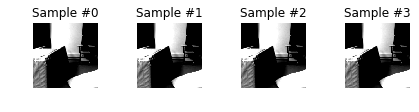

In [27]:
for i in range(len(image_dataset)):
    sample = image_dataset[i]

#     print(i, sample['image'].shape, sample['labels'].shape)
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    imshow(torchvision.utils.make_grid(image_dataset[i][0]))
#     show_image(image_dataset[i]['image'])

    if i == 3:
        plt.show()
        break

In [28]:
#load the data

dataloader = DataLoader(image_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

#load the data

newdataloader = DataLoader(newdataset, batch_size=64,
                        shuffle=True, num_workers=0)

0 torch.Size([64, 3, 224, 224]) torch.Size([64, 7])
1 torch.Size([64, 3, 224, 224]) torch.Size([64, 7])
2 torch.Size([64, 3, 224, 224]) torch.Size([64, 7])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([64, 3, 224, 224]) torch.Size([64, 7])


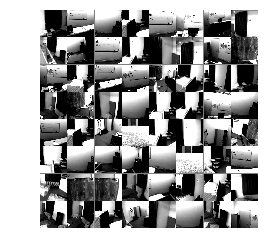

In [29]:
# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        imshow(torchvision.utils.make_grid(sample_batched[0]))
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

#### Split into Training and Validation 

In [31]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)



In [32]:
def calculate_img_stats_avg(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for imgs,_,_ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std

In [33]:
mean, std = calculate_img_stats_avg(train_loader)

In [34]:
def calculate_img_stats_full(dataset):
    imgs_ = torch.stack([img for img,_,_ in dataset],dim=3)
    imgs_ = imgs_.view(3,-1)
    imgs_mean = imgs_.mean(dim=1)
    imgs_std = imgs_.std(dim=1)
    return imgs_mean,imgs_std

In [35]:
imgs_mean,imgs_std = calculate_img_stats_full(newdataset)


In [36]:
imgs_mean

tensor([0.4543, 0.4543, 0.4543])

# Functions

In [37]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

# Feature Extractore Network +  Regressor for Camera translation and rotation

## IMU Network 

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class IMUFCNet(nn.Module):
    def __init__(self):
        super(IMUFCNet, self).__init__()
        self.fc1 = nn.Linear(64, 1000)
        self.fc2 = nn.Linear(1000, 100)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))


In [40]:
imu_net = IMUFCNet()
print(imu_net)

IMUFCNet(
  (fc1): Linear(in_features=64, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
)


In [42]:
class IMUNet(torch.nn.Module):


    def __init__(self, feature_extractor, num_features=128, dropout=0.5,
                 track_running_stats=False, pretrained=False):
        super(IMUNet, self).__init__()
        self.dropout = dropout
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        
        self.fc1 = torch.nn.Linear(6,100)
        self.fc2 = torch.nn.Linear( 2337000,100)


        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features + 100, 3)

        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features + 100, 4)
        
    def extract_features(self, image):
        x_features = self.feature_extractor(image)
        x_features = F.relu(x_features)
        if self.dropout > 0:
            x_features = F.dropout(x_features, p=self.dropout, training=self.training)
        return x_features
    
    def forward(self, image, imu_data):
        
        #Images
        if type(image) is list:
            x_features = [self.extract_features(xi) for xi in image]
        elif torch.is_tensor(image):
            x_features = self.extract_features(image)
            
            
        imu_features = F.relu(self.fc1(imu_data))
        imu_features = imu_features.view(imu_features.size()[0], -1)
        imu_features = F.relu(self.fc2(imu_features))


        x = torch.cat((x_features, imu_features), dim=1)

        if type(x) is list:
            x_translations = [self.fc_xyz(xi) for xi in x]
            x_rotations = [self.fc_quat(xi) for xi in x]
            x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]  
        elif torch.is_tensor(x):
            x_translations = self.fc_xyz(x) 
            x_rotations = self.fc_quat(x)
            x_poses = torch.cat((x_translations, x_rotations), dim=1)

        return x_poses

In [43]:

import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet50(pretrained=True)



In [44]:
class NetCriterion(torch.nn.Module):
    def __init__(self, beta = 512.0, learn_beta=False, sx=0.0, sq=-3.0):
        super(NetCriterion, self).__init__()
        self.loss_fn = torch.nn.L1Loss()
#         self.loss_fn = torch.nn.MSELoss()
        self.learn_beta = learn_beta
        if not learn_beta:
            self.beta = beta
        else:
            self.beta = 1.0
        self.sx = torch.nn.Parameter(torch.Tensor([sx]), requires_grad=learn_beta)
        self.sq = torch.nn.Parameter(torch.Tensor([sq]), requires_grad=learn_beta)

    def forward(self, x, y):
        """
        Args:
            x: list(N x 7, N x 7) - prediction (xyz, quat)
            y: list(N x 7, N x 7) - target (xyz, quat)
        """
        
        loss = 0
        # Translation loss
        loss = torch.exp(-self.sx) * self.loss_fn(x[:, :3], y[:, :3]) 
        # Rotation loss
        loss += torch.exp(-self.sq) * self.beta * self.loss_fn(x[:, 3:], y[:, 3:]) + self.sq

        return loss

In [45]:
# Select primary device

import os

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    

In [47]:
next(iter(train_loader))[1]

tensor([[[ 2.0246e-02,  1.6755e-02,  8.6568e-02,  1.0150e+01, -2.4517e-02,
          -3.2035e+00],
         [ 2.0944e-02,  3.8397e-02,  8.5870e-02,  8.9241e+00,  1.4710e-01,
          -2.4271e+00],
         [ 9.0757e-03,  2.5831e-02,  9.2852e-02,  9.6269e+00,  1.7162e-01,
          -2.8439e+00],
         ...,
         [-3.4907e-03,  2.5133e-02,  8.5172e-02,  9.3081e+00, -8.1722e-03,
          -2.8194e+00],
         [-7.6794e-03,  2.6529e-02,  8.2380e-02,  9.3081e+00, -8.9894e-02,
          -2.7949e+00],
         [-2.7925e-03,  1.5359e-02,  8.2380e-02,  9.4307e+00, -2.4517e-02,
          -2.7867e+00]],

        [[ 2.0246e-02,  1.6755e-02,  8.6568e-02,  1.0150e+01, -2.4517e-02,
          -3.2035e+00],
         [ 2.0944e-02,  3.8397e-02,  8.5870e-02,  8.9241e+00,  1.4710e-01,
          -2.4271e+00],
         [ 9.0757e-03,  2.5831e-02,  9.2852e-02,  9.6269e+00,  1.7162e-01,
          -2.8439e+00],
         ...,
         [-3.4907e-03,  2.5133e-02,  8.5172e-02,  9.3081e+00, -8.1722e-03,
    

In [48]:
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count

In [49]:
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    model.train()
    losses = AverageMeter()
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    end = time.time()
    
    for idx, (batch_images, imu_data, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        batch_images = batch_images.to(device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
#         imu_data = imu_data.to(device).double()
        imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)


#         imu_data = imu_data.double()
        
        out = model(batch_images, imu_data)
        loss = criterion(out, batch_poses)
        
        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.data[0], len(batch_images) * batch_images.size(0))
        
        
        # move data to cpu & numpy
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
        t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
        q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

        return losses
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, imu_data, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
            batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
            imu_data = imu_data.to(device)
            imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)


            # compute model output
            out = model(batch_images,  imu_data)
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(batch_images) * batch_images.size(0))
            batch_time = time.time() - end
            end = time.time()
#             print(idx % log_freq)
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    return losses


In [50]:
import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet50(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048


In [52]:

imu = next(iter(train_loader))[1]
# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)

# Criterion
criterion = NetCriterion(learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    # Add sx and sq from loss function to optimizer params
    param_list.append({'params': criterion.parameters()})

# Create optimizer
# optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)
optimizer = optim.Adam(params=param_list, lr=0.0001, weight_decay=0.0001)


# Epochs to train
start_epoch = 0

# n_epochs = 10

In [53]:
n_epochs = start_epoch + 2000
train_loss=[]
test_loss=[]
print('Training ...')
val_freq = 10
for e in range(start_epoch, n_epochs):
    losses = train(train_loader, model, criterion, optimizer, e, n_epochs, log_freq=100)
    train_loss.append(losses)
    if e % val_freq == 0:
#         end = time.time()
        loss = validate(validation_loader, model, criterion, e, log_freq=100)
        test_loss.append(loss)


start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))

Training ...
Epoch: [0/1999]	Batch: [0/24]	Time: 0.935	Data Time: 0.476	Loss: 8.075	Avg Loss: 8.075	
Val Epoch: 0	Time: 0.609	Data Time: 0.484	Loss: 592.736	Avg Loss: 592.736
Epoch: [1/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.478	Loss: 595.090	Avg Loss: 595.090	
Epoch: [2/1999]	Batch: [0/24]	Time: 0.921	Data Time: 0.482	Loss: 469.946	Avg Loss: 469.946	
Epoch: [3/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.481	Loss: 280.576	Avg Loss: 280.576	
Epoch: [4/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.479	Loss: 115.503	Avg Loss: 115.503	
Epoch: [5/1999]	Batch: [0/24]	Time: 0.918	Data Time: 0.481	Loss: 83.450	Avg Loss: 83.450	
Epoch: [6/1999]	Batch: [0/24]	Time: 0.903	Data Time: 0.482	Loss: 60.475	Avg Loss: 60.475	
Epoch: [7/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.483	Loss: 63.343	Avg Loss: 63.343	
Epoch: [8/1999]	Batch: [0/24]	Time: 0.921	Data Time: 0.477	Loss: 50.911	Avg Loss: 50.911	
Epoch: [9/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.490	Loss: 22.578	Avg Loss: 22.578	
Epoch: 

Epoch: [83/1999]	Batch: [0/24]	Time: 0.895	Data Time: 0.472	Loss: 26.944	Avg Loss: 26.944	
Epoch: [84/1999]	Batch: [0/24]	Time: 0.898	Data Time: 0.479	Loss: 27.565	Avg Loss: 27.565	
Epoch: [85/1999]	Batch: [0/24]	Time: 0.920	Data Time: 0.478	Loss: 46.029	Avg Loss: 46.029	
Epoch: [86/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.484	Loss: 44.280	Avg Loss: 44.280	
Epoch: [87/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.483	Loss: 25.515	Avg Loss: 25.515	
Epoch: [88/1999]	Batch: [0/24]	Time: 0.898	Data Time: 0.480	Loss: 22.847	Avg Loss: 22.847	
Epoch: [89/1999]	Batch: [0/24]	Time: 0.930	Data Time: 0.485	Loss: 55.229	Avg Loss: 55.229	
Epoch: [90/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.483	Loss: 39.499	Avg Loss: 39.499	
Val Epoch: 90	Time: 0.607	Data Time: 0.481	Loss: 33.682	Avg Loss: 33.682
Epoch: [91/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.479	Loss: 35.846	Avg Loss: 35.846	
Epoch: [92/1999]	Batch: [0/24]	Time: 0.918	Data Time: 0.483	Loss: 43.165	Avg Loss: 43.165	
Epoch: [93/1999]	

Epoch: [166/1999]	Batch: [0/24]	Time: 0.904	Data Time: 0.474	Loss: 28.960	Avg Loss: 28.960	
Epoch: [167/1999]	Batch: [0/24]	Time: 0.923	Data Time: 0.486	Loss: 16.075	Avg Loss: 16.075	
Epoch: [168/1999]	Batch: [0/24]	Time: 0.919	Data Time: 0.475	Loss: 30.266	Avg Loss: 30.266	
Epoch: [169/1999]	Batch: [0/24]	Time: 0.931	Data Time: 0.499	Loss: 37.420	Avg Loss: 37.420	
Epoch: [170/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.487	Loss: 24.781	Avg Loss: 24.781	
Val Epoch: 170	Time: 0.605	Data Time: 0.481	Loss: 22.707	Avg Loss: 22.707
Epoch: [171/1999]	Batch: [0/24]	Time: 0.912	Data Time: 0.480	Loss: 22.500	Avg Loss: 22.500	
Epoch: [172/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.479	Loss: 29.876	Avg Loss: 29.876	
Epoch: [173/1999]	Batch: [0/24]	Time: 0.932	Data Time: 0.487	Loss: 15.741	Avg Loss: 15.741	
Epoch: [174/1999]	Batch: [0/24]	Time: 0.922	Data Time: 0.489	Loss: 19.170	Avg Loss: 19.170	
Epoch: [175/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.475	Loss: 32.767	Avg Loss: 32.767	
Epoch:

Epoch: [249/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.479	Loss: 18.075	Avg Loss: 18.075	
Epoch: [250/1999]	Batch: [0/24]	Time: 0.903	Data Time: 0.482	Loss: 22.180	Avg Loss: 22.180	
Val Epoch: 250	Time: 0.604	Data Time: 0.479	Loss: 16.790	Avg Loss: 16.790
Epoch: [251/1999]	Batch: [0/24]	Time: 0.892	Data Time: 0.480	Loss: 16.584	Avg Loss: 16.584	
Epoch: [252/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.480	Loss: 13.746	Avg Loss: 13.746	
Epoch: [253/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.477	Loss: 16.494	Avg Loss: 16.494	
Epoch: [254/1999]	Batch: [0/24]	Time: 0.912	Data Time: 0.481	Loss: 19.788	Avg Loss: 19.788	
Epoch: [255/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.485	Loss: 22.963	Avg Loss: 22.963	
Epoch: [256/1999]	Batch: [0/24]	Time: 0.922	Data Time: 0.478	Loss: 30.811	Avg Loss: 30.811	
Epoch: [257/1999]	Batch: [0/24]	Time: 0.904	Data Time: 0.482	Loss: 20.402	Avg Loss: 20.402	
Epoch: [258/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.482	Loss: 11.081	Avg Loss: 11.081	
Epoch:

Epoch: [331/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.479	Loss: 24.627	Avg Loss: 24.627	
Epoch: [332/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.484	Loss: 28.471	Avg Loss: 28.471	
Epoch: [333/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.478	Loss: 24.582	Avg Loss: 24.582	
Epoch: [334/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.474	Loss: 30.532	Avg Loss: 30.532	
Epoch: [335/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.485	Loss: 38.674	Avg Loss: 38.674	
Epoch: [336/1999]	Batch: [0/24]	Time: 0.925	Data Time: 0.479	Loss: 33.806	Avg Loss: 33.806	
Epoch: [337/1999]	Batch: [0/24]	Time: 0.940	Data Time: 0.503	Loss: 16.400	Avg Loss: 16.400	
Epoch: [338/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.482	Loss: 36.887	Avg Loss: 36.887	
Epoch: [339/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.482	Loss: 42.127	Avg Loss: 42.127	
Epoch: [340/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.478	Loss: 34.716	Avg Loss: 34.716	
Val Epoch: 340	Time: 0.616	Data Time: 0.488	Loss: 28.627	Avg Loss: 28.627
Epoch:

Epoch: [414/1999]	Batch: [0/24]	Time: 0.961	Data Time: 0.515	Loss: 5.461	Avg Loss: 5.461	
Epoch: [415/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.488	Loss: 9.537	Avg Loss: 9.537	
Epoch: [416/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.483	Loss: 6.459	Avg Loss: 6.459	
Epoch: [417/1999]	Batch: [0/24]	Time: 0.944	Data Time: 0.524	Loss: 12.027	Avg Loss: 12.027	
Epoch: [418/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.480	Loss: 11.959	Avg Loss: 11.959	
Epoch: [419/1999]	Batch: [0/24]	Time: 0.893	Data Time: 0.472	Loss: 8.617	Avg Loss: 8.617	
Epoch: [420/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.477	Loss: 17.023	Avg Loss: 17.023	
Val Epoch: 420	Time: 0.615	Data Time: 0.491	Loss: 22.997	Avg Loss: 22.997
Epoch: [421/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.484	Loss: 23.131	Avg Loss: 23.131	
Epoch: [422/1999]	Batch: [0/24]	Time: 0.916	Data Time: 0.485	Loss: 16.782	Avg Loss: 16.782	
Epoch: [423/1999]	Batch: [0/24]	Time: 0.925	Data Time: 0.479	Loss: 8.977	Avg Loss: 8.977	
Epoch: [424/1999

Epoch: [498/1999]	Batch: [0/24]	Time: 0.930	Data Time: 0.486	Loss: 18.604	Avg Loss: 18.604	
Epoch: [499/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.480	Loss: 15.376	Avg Loss: 15.376	
Epoch: [500/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.478	Loss: 2.488	Avg Loss: 2.488	
Val Epoch: 500	Time: 0.602	Data Time: 0.479	Loss: 7.957	Avg Loss: 7.957
Epoch: [501/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.483	Loss: 8.586	Avg Loss: 8.586	
Epoch: [502/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.489	Loss: 5.811	Avg Loss: 5.811	
Epoch: [503/1999]	Batch: [0/24]	Time: 0.918	Data Time: 0.487	Loss: 12.225	Avg Loss: 12.225	
Epoch: [504/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.478	Loss: 12.372	Avg Loss: 12.372	
Epoch: [505/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.487	Loss: 5.492	Avg Loss: 5.492	
Epoch: [506/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.476	Loss: 14.704	Avg Loss: 14.704	
Epoch: [507/1999]	Batch: [0/24]	Time: 0.931	Data Time: 0.505	Loss: 17.954	Avg Loss: 17.954	
Epoch: [508/1999

Epoch: [581/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.477	Loss: 14.583	Avg Loss: 14.583	
Epoch: [582/1999]	Batch: [0/24]	Time: 0.898	Data Time: 0.481	Loss: 10.025	Avg Loss: 10.025	
Epoch: [583/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.479	Loss: 4.419	Avg Loss: 4.419	
Epoch: [584/1999]	Batch: [0/24]	Time: 0.925	Data Time: 0.485	Loss: 12.249	Avg Loss: 12.249	
Epoch: [585/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.477	Loss: 10.121	Avg Loss: 10.121	
Epoch: [586/1999]	Batch: [0/24]	Time: 0.975	Data Time: 0.536	Loss: 7.296	Avg Loss: 7.296	
Epoch: [587/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.481	Loss: 8.152	Avg Loss: 8.152	
Epoch: [588/1999]	Batch: [0/24]	Time: 0.919	Data Time: 0.482	Loss: 5.849	Avg Loss: 5.849	
Epoch: [589/1999]	Batch: [0/24]	Time: 0.899	Data Time: 0.476	Loss: 6.821	Avg Loss: 6.821	
Epoch: [590/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.486	Loss: 9.430	Avg Loss: 9.430	
Val Epoch: 590	Time: 0.591	Data Time: 0.476	Loss: 6.438	Avg Loss: 6.438
Epoch: [591/1999]	Ba

Epoch: [665/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.482	Loss: 9.624	Avg Loss: 9.624	
Epoch: [666/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.482	Loss: 2.667	Avg Loss: 2.667	
Epoch: [667/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.484	Loss: 8.847	Avg Loss: 8.847	
Epoch: [668/1999]	Batch: [0/24]	Time: 0.885	Data Time: 0.454	Loss: 8.581	Avg Loss: 8.581	
Epoch: [669/1999]	Batch: [0/24]	Time: 0.930	Data Time: 0.507	Loss: 0.496	Avg Loss: 0.496	
Epoch: [670/1999]	Batch: [0/24]	Time: 0.917	Data Time: 0.484	Loss: 10.218	Avg Loss: 10.218	
Val Epoch: 670	Time: 0.598	Data Time: 0.482	Loss: 10.154	Avg Loss: 10.154
Epoch: [671/1999]	Batch: [0/24]	Time: 0.916	Data Time: 0.486	Loss: 10.181	Avg Loss: 10.181	
Epoch: [672/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.483	Loss: 3.253	Avg Loss: 3.253	
Epoch: [673/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.486	Loss: 1.787	Avg Loss: 1.787	
Epoch: [674/1999]	Batch: [0/24]	Time: 0.926	Data Time: 0.488	Loss: 2.081	Avg Loss: 2.081	
Epoch: [675/1999]	Batc

Epoch: [750/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.477	Loss: 0.531	Avg Loss: 0.531	
Val Epoch: 750	Time: 0.595	Data Time: 0.479	Loss: 5.408	Avg Loss: 5.408
Epoch: [751/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.482	Loss: 5.469	Avg Loss: 5.469	
Epoch: [752/1999]	Batch: [0/24]	Time: 0.896	Data Time: 0.463	Loss: 3.638	Avg Loss: 3.638	
Epoch: [753/1999]	Batch: [0/24]	Time: 0.928	Data Time: 0.482	Loss: 4.526	Avg Loss: 4.526	
Epoch: [754/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.484	Loss: 7.054	Avg Loss: 7.054	
Epoch: [755/1999]	Batch: [0/24]	Time: 0.895	Data Time: 0.480	Loss: 0.409	Avg Loss: 0.409	
Epoch: [756/1999]	Batch: [0/24]	Time: 0.898	Data Time: 0.481	Loss: 9.170	Avg Loss: 9.170	
Epoch: [757/1999]	Batch: [0/24]	Time: 0.930	Data Time: 0.483	Loss: 13.297	Avg Loss: 13.297	
Epoch: [758/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.485	Loss: 9.183	Avg Loss: 9.183	
Epoch: [759/1999]	Batch: [0/24]	Time: 0.899	Data Time: 0.478	Loss: 2.464	Avg Loss: 2.464	
Epoch: [760/1999]	Batch: [

Epoch: [834/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.486	Loss: 2.777	Avg Loss: 2.777	
Epoch: [835/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.473	Loss: 2.677	Avg Loss: 2.677	
Epoch: [836/1999]	Batch: [0/24]	Time: 0.935	Data Time: 0.516	Loss: 2.589	Avg Loss: 2.589	
Epoch: [837/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.484	Loss: 1.336	Avg Loss: 1.336	
Epoch: [838/1999]	Batch: [0/24]	Time: 0.922	Data Time: 0.481	Loss: 3.448	Avg Loss: 3.448	
Epoch: [839/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.482	Loss: 2.332	Avg Loss: 2.332	
Epoch: [840/1999]	Batch: [0/24]	Time: 0.948	Data Time: 0.517	Loss: 3.344	Avg Loss: 3.344	
Val Epoch: 840	Time: 0.596	Data Time: 0.483	Loss: 1.966	Avg Loss: 1.966
Epoch: [841/1999]	Batch: [0/24]	Time: 0.917	Data Time: 0.480	Loss: 2.321	Avg Loss: 2.321	
Epoch: [842/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.484	Loss: 1.742	Avg Loss: 1.742	
Epoch: [843/1999]	Batch: [0/24]	Time: 0.894	Data Time: 0.475	Loss: 1.292	Avg Loss: 1.292	
Epoch: [844/1999]	Batch: [0/

Epoch: [919/1999]	Batch: [0/24]	Time: 0.916	Data Time: 0.485	Loss: 0.254	Avg Loss: 0.254	
Epoch: [920/1999]	Batch: [0/24]	Time: 0.931	Data Time: 0.485	Loss: 5.391	Avg Loss: 5.391	
Val Epoch: 920	Time: 0.592	Data Time: 0.482	Loss: 6.699	Avg Loss: 6.699
Epoch: [921/1999]	Batch: [0/24]	Time: 0.904	Data Time: 0.479	Loss: 6.664	Avg Loss: 6.664	
Epoch: [922/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.481	Loss: 1.184	Avg Loss: 1.184	
Epoch: [923/1999]	Batch: [0/24]	Time: 0.927	Data Time: 0.482	Loss: 7.868	Avg Loss: 7.868	
Epoch: [924/1999]	Batch: [0/24]	Time: 0.932	Data Time: 0.485	Loss: 10.716	Avg Loss: 10.716	
Epoch: [925/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.481	Loss: 7.968	Avg Loss: 7.968	
Epoch: [926/1999]	Batch: [0/24]	Time: 0.917	Data Time: 0.486	Loss: 0.520	Avg Loss: 0.520	
Epoch: [927/1999]	Batch: [0/24]	Time: 0.941	Data Time: 0.522	Loss: 10.531	Avg Loss: 10.531	
Epoch: [928/1999]	Batch: [0/24]	Time: 0.926	Data Time: 0.485	Loss: 12.611	Avg Loss: 12.611	
Epoch: [929/1999]	Batc

Epoch: [1003/1999]	Batch: [0/24]	Time: 0.904	Data Time: 0.482	Loss: 1.694	Avg Loss: 1.694	
Epoch: [1004/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.481	Loss: 1.752	Avg Loss: 1.752	
Epoch: [1005/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.477	Loss: -0.536	Avg Loss: -0.536	
Epoch: [1006/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.480	Loss: 1.291	Avg Loss: 1.291	
Epoch: [1007/1999]	Batch: [0/24]	Time: 0.912	Data Time: 0.481	Loss: 0.330	Avg Loss: 0.330	
Epoch: [1008/1999]	Batch: [0/24]	Time: 0.929	Data Time: 0.486	Loss: 0.035	Avg Loss: 0.035	
Epoch: [1009/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.482	Loss: 1.511	Avg Loss: 1.511	
Epoch: [1010/1999]	Batch: [0/24]	Time: 0.923	Data Time: 0.490	Loss: -0.043	Avg Loss: -0.043	
Val Epoch: 1010	Time: 0.603	Data Time: 0.478	Loss: -0.695	Avg Loss: -0.695
Epoch: [1011/1999]	Batch: [0/24]	Time: 0.903	Data Time: 0.482	Loss: -0.325	Avg Loss: -0.325	
Epoch: [1012/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.483	Loss: 1.501	Avg Loss: 1.501	
Epoch: [1

Epoch: [1087/1999]	Batch: [0/24]	Time: 0.922	Data Time: 0.478	Loss: 1.587	Avg Loss: 1.587	
Epoch: [1088/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.483	Loss: 0.863	Avg Loss: 0.863	
Epoch: [1089/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.485	Loss: 0.866	Avg Loss: 0.866	
Epoch: [1090/1999]	Batch: [0/24]	Time: 0.926	Data Time: 0.481	Loss: 0.749	Avg Loss: 0.749	
Val Epoch: 1090	Time: 0.589	Data Time: 0.477	Loss: -0.119	Avg Loss: -0.119
Epoch: [1091/1999]	Batch: [0/24]	Time: 0.923	Data Time: 0.495	Loss: 0.015	Avg Loss: 0.015	
Epoch: [1092/1999]	Batch: [0/24]	Time: 0.945	Data Time: 0.521	Loss: 2.671	Avg Loss: 2.671	
Epoch: [1093/1999]	Batch: [0/24]	Time: 0.919	Data Time: 0.480	Loss: 1.399	Avg Loss: 1.399	
Epoch: [1094/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.483	Loss: 0.539	Avg Loss: 0.539	
Epoch: [1095/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.481	Loss: 0.155	Avg Loss: 0.155	
Epoch: [1096/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.480	Loss: 1.023	Avg Loss: 1.023	
Epoch: [1097/19

Val Epoch: 1170	Time: 0.594	Data Time: 0.474	Loss: -0.421	Avg Loss: -0.421
Epoch: [1171/1999]	Batch: [0/24]	Time: 0.899	Data Time: 0.478	Loss: -0.083	Avg Loss: -0.083	
Epoch: [1172/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.480	Loss: -1.096	Avg Loss: -1.096	
Epoch: [1173/1999]	Batch: [0/24]	Time: 0.947	Data Time: 0.516	Loss: -1.147	Avg Loss: -1.147	
Epoch: [1174/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.484	Loss: 0.531	Avg Loss: 0.531	
Epoch: [1175/1999]	Batch: [0/24]	Time: 0.924	Data Time: 0.487	Loss: -1.136	Avg Loss: -1.136	
Epoch: [1176/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.478	Loss: 1.421	Avg Loss: 1.421	
Epoch: [1177/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.489	Loss: 0.900	Avg Loss: 0.900	
Epoch: [1178/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.483	Loss: 0.264	Avg Loss: 0.264	
Epoch: [1179/1999]	Batch: [0/24]	Time: 0.917	Data Time: 0.485	Loss: 0.589	Avg Loss: 0.589	
Epoch: [1180/1999]	Batch: [0/24]	Time: 0.965	Data Time: 0.535	Loss: 0.074	Avg Loss: 0.074	
Val Epo

Epoch: [1253/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.486	Loss: 0.303	Avg Loss: 0.303	
Epoch: [1254/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.484	Loss: 0.520	Avg Loss: 0.520	
Epoch: [1255/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.478	Loss: -0.333	Avg Loss: -0.333	
Epoch: [1256/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.481	Loss: 1.453	Avg Loss: 1.453	
Epoch: [1257/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.480	Loss: 1.347	Avg Loss: 1.347	
Epoch: [1258/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.486	Loss: -0.029	Avg Loss: -0.029	
Epoch: [1259/1999]	Batch: [0/24]	Time: 0.927	Data Time: 0.489	Loss: -0.361	Avg Loss: -0.361	
Epoch: [1260/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.483	Loss: 1.012	Avg Loss: 1.012	
Val Epoch: 1260	Time: 0.602	Data Time: 0.477	Loss: 0.521	Avg Loss: 0.521
Epoch: [1261/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.478	Loss: 0.773	Avg Loss: 0.773	
Epoch: [1262/1999]	Batch: [0/24]	Time: 0.917	Data Time: 0.482	Loss: -0.230	Avg Loss: -0.230	
Epoch: [1

Epoch: [1336/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.483	Loss: -0.579	Avg Loss: -0.579	
Epoch: [1337/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.480	Loss: 0.863	Avg Loss: 0.863	
Epoch: [1338/1999]	Batch: [0/24]	Time: 0.903	Data Time: 0.480	Loss: 0.162	Avg Loss: 0.162	
Epoch: [1339/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.477	Loss: 0.756	Avg Loss: 0.756	
Epoch: [1340/1999]	Batch: [0/24]	Time: 0.924	Data Time: 0.478	Loss: 0.904	Avg Loss: 0.904	
Val Epoch: 1340	Time: 0.594	Data Time: 0.478	Loss: -0.952	Avg Loss: -0.952
Epoch: [1341/1999]	Batch: [0/24]	Time: 0.918	Data Time: 0.487	Loss: -0.434	Avg Loss: -0.434	
Epoch: [1342/1999]	Batch: [0/24]	Time: 0.927	Data Time: 0.483	Loss: -1.037	Avg Loss: -1.037	
Epoch: [1343/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.484	Loss: 0.313	Avg Loss: 0.313	
Epoch: [1344/1999]	Batch: [0/24]	Time: 0.896	Data Time: 0.479	Loss: -0.814	Avg Loss: -0.814	
Epoch: [1345/1999]	Batch: [0/24]	Time: 0.917	Data Time: 0.492	Loss: 0.446	Avg Loss: 0.446	
Epoch: 

Epoch: [1419/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.479	Loss: 0.430	Avg Loss: 0.430	
Epoch: [1420/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.469	Loss: 0.162	Avg Loss: 0.162	
Val Epoch: 1420	Time: 0.609	Data Time: 0.481	Loss: -0.660	Avg Loss: -0.660
Epoch: [1421/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.482	Loss: -0.449	Avg Loss: -0.449	
Epoch: [1422/1999]	Batch: [0/24]	Time: 0.922	Data Time: 0.480	Loss: -0.348	Avg Loss: -0.348	
Epoch: [1423/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.473	Loss: -0.278	Avg Loss: -0.278	
Epoch: [1424/1999]	Batch: [0/24]	Time: 0.892	Data Time: 0.476	Loss: -0.356	Avg Loss: -0.356	
Epoch: [1425/1999]	Batch: [0/24]	Time: 0.927	Data Time: 0.482	Loss: -0.311	Avg Loss: -0.311	
Epoch: [1426/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.485	Loss: -0.472	Avg Loss: -0.472	
Epoch: [1427/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.477	Loss: -0.211	Avg Loss: -0.211	
Epoch: [1428/1999]	Batch: [0/24]	Time: 0.929	Data Time: 0.483	Loss: -0.484	Avg Loss: -0.484	

Epoch: [1501/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.482	Loss: -0.624	Avg Loss: -0.624	
Epoch: [1502/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.482	Loss: -0.461	Avg Loss: -0.461	
Epoch: [1503/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.481	Loss: -0.368	Avg Loss: -0.368	
Epoch: [1504/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.481	Loss: 0.112	Avg Loss: 0.112	
Epoch: [1505/1999]	Batch: [0/24]	Time: 0.928	Data Time: 0.483	Loss: -0.507	Avg Loss: -0.507	
Epoch: [1506/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.477	Loss: -1.015	Avg Loss: -1.015	
Epoch: [1507/1999]	Batch: [0/24]	Time: 0.892	Data Time: 0.479	Loss: 0.062	Avg Loss: 0.062	
Epoch: [1508/1999]	Batch: [0/24]	Time: 0.935	Data Time: 0.517	Loss: -0.485	Avg Loss: -0.485	
Epoch: [1509/1999]	Batch: [0/24]	Time: 0.895	Data Time: 0.466	Loss: 0.296	Avg Loss: 0.296	
Epoch: [1510/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.478	Loss: 0.263	Avg Loss: 0.263	
Val Epoch: 1510	Time: 0.606	Data Time: 0.480	Loss: -1.045	Avg Loss: -1.045
Epo

Epoch: [1584/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.475	Loss: -0.442	Avg Loss: -0.442	
Epoch: [1585/1999]	Batch: [0/24]	Time: 0.926	Data Time: 0.477	Loss: -0.563	Avg Loss: -0.563	
Epoch: [1586/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.477	Loss: -0.944	Avg Loss: -0.944	
Epoch: [1587/1999]	Batch: [0/24]	Time: 0.908	Data Time: 0.478	Loss: -0.180	Avg Loss: -0.180	
Epoch: [1588/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.477	Loss: -0.901	Avg Loss: -0.901	
Epoch: [1589/1999]	Batch: [0/24]	Time: 0.927	Data Time: 0.479	Loss: 0.347	Avg Loss: 0.347	
Epoch: [1590/1999]	Batch: [0/24]	Time: 0.912	Data Time: 0.484	Loss: -0.286	Avg Loss: -0.286	
Val Epoch: 1590	Time: 0.600	Data Time: 0.483	Loss: -0.554	Avg Loss: -0.554
Epoch: [1591/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.478	Loss: -0.400	Avg Loss: -0.400	
Epoch: [1592/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.476	Loss: -1.047	Avg Loss: -1.047	
Epoch: [1593/1999]	Batch: [0/24]	Time: 0.918	Data Time: 0.483	Loss: -0.787	Avg Loss: -0.78

Epoch: [1666/1999]	Batch: [0/24]	Time: 0.934	Data Time: 0.495	Loss: -0.820	Avg Loss: -0.820	
Epoch: [1667/1999]	Batch: [0/24]	Time: 0.910	Data Time: 0.480	Loss: -1.455	Avg Loss: -1.455	
Epoch: [1668/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.482	Loss: -0.280	Avg Loss: -0.280	
Epoch: [1669/1999]	Batch: [0/24]	Time: 0.924	Data Time: 0.479	Loss: -0.804	Avg Loss: -0.804	
Epoch: [1670/1999]	Batch: [0/24]	Time: 0.916	Data Time: 0.485	Loss: -0.324	Avg Loss: -0.324	
Val Epoch: 1670	Time: 0.606	Data Time: 0.478	Loss: -1.158	Avg Loss: -1.158
Epoch: [1671/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.477	Loss: -0.837	Avg Loss: -0.837	
Epoch: [1672/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.481	Loss: -0.389	Avg Loss: -0.389	
Epoch: [1673/1999]	Batch: [0/24]	Time: 0.902	Data Time: 0.484	Loss: -0.545	Avg Loss: -0.545	
Epoch: [1674/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.483	Loss: -0.992	Avg Loss: -0.992	
Epoch: [1675/1999]	Batch: [0/24]	Time: 0.914	Data Time: 0.485	Loss: -0.591	Avg Loss: -0.

Epoch: [1748/1999]	Batch: [0/24]	Time: 0.912	Data Time: 0.481	Loss: -0.278	Avg Loss: -0.278	
Epoch: [1749/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.489	Loss: -1.492	Avg Loss: -1.492	
Epoch: [1750/1999]	Batch: [0/24]	Time: 0.921	Data Time: 0.483	Loss: 0.093	Avg Loss: 0.093	
Val Epoch: 1750	Time: 0.604	Data Time: 0.481	Loss: -1.025	Avg Loss: -1.025
Epoch: [1751/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.485	Loss: -0.790	Avg Loss: -0.790	
Epoch: [1752/1999]	Batch: [0/24]	Time: 0.919	Data Time: 0.479	Loss: 0.130	Avg Loss: 0.130	
Epoch: [1753/1999]	Batch: [0/24]	Time: 0.916	Data Time: 0.486	Loss: -0.447	Avg Loss: -0.447	
Epoch: [1754/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.483	Loss: -0.943	Avg Loss: -0.943	
Epoch: [1755/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.479	Loss: -0.619	Avg Loss: -0.619	
Epoch: [1756/1999]	Batch: [0/24]	Time: 0.900	Data Time: 0.484	Loss: -0.586	Avg Loss: -0.586	
Epoch: [1757/1999]	Batch: [0/24]	Time: 0.904	Data Time: 0.484	Loss: -0.579	Avg Loss: -0.579	

Epoch: [1830/1999]	Batch: [0/24]	Time: 0.893	Data Time: 0.474	Loss: -1.623	Avg Loss: -1.623	
Val Epoch: 1830	Time: 0.604	Data Time: 0.483	Loss: -1.378	Avg Loss: -1.378
Epoch: [1831/1999]	Batch: [0/24]	Time: 0.919	Data Time: 0.487	Loss: -1.190	Avg Loss: -1.190	
Epoch: [1832/1999]	Batch: [0/24]	Time: 0.903	Data Time: 0.478	Loss: -1.833	Avg Loss: -1.833	
Epoch: [1833/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.478	Loss: -1.150	Avg Loss: -1.150	
Epoch: [1834/1999]	Batch: [0/24]	Time: 0.916	Data Time: 0.484	Loss: -1.808	Avg Loss: -1.808	
Epoch: [1835/1999]	Batch: [0/24]	Time: 0.911	Data Time: 0.480	Loss: -1.239	Avg Loss: -1.239	
Epoch: [1836/1999]	Batch: [0/24]	Time: 0.901	Data Time: 0.481	Loss: -1.401	Avg Loss: -1.401	
Epoch: [1837/1999]	Batch: [0/24]	Time: 0.933	Data Time: 0.485	Loss: -1.738	Avg Loss: -1.738	
Epoch: [1838/1999]	Batch: [0/24]	Time: 0.930	Data Time: 0.485	Loss: -1.568	Avg Loss: -1.568	
Epoch: [1839/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.485	Loss: -1.480	Avg Loss: -1.

Epoch: [1912/1999]	Batch: [0/24]	Time: 0.913	Data Time: 0.484	Loss: -0.359	Avg Loss: -0.359	
Epoch: [1913/1999]	Batch: [0/24]	Time: 0.926	Data Time: 0.480	Loss: 0.483	Avg Loss: 0.483	
Epoch: [1914/1999]	Batch: [0/24]	Time: 0.892	Data Time: 0.475	Loss: 0.815	Avg Loss: 0.815	
Epoch: [1915/1999]	Batch: [0/24]	Time: 0.906	Data Time: 0.481	Loss: -0.366	Avg Loss: -0.366	
Epoch: [1916/1999]	Batch: [0/24]	Time: 0.890	Data Time: 0.474	Loss: -1.110	Avg Loss: -1.110	
Epoch: [1917/1999]	Batch: [0/24]	Time: 0.893	Data Time: 0.478	Loss: 0.509	Avg Loss: 0.509	
Epoch: [1918/1999]	Batch: [0/24]	Time: 0.907	Data Time: 0.474	Loss: -0.623	Avg Loss: -0.623	
Epoch: [1919/1999]	Batch: [0/24]	Time: 0.904	Data Time: 0.475	Loss: -0.622	Avg Loss: -0.622	
Epoch: [1920/1999]	Batch: [0/24]	Time: 0.929	Data Time: 0.483	Loss: -0.463	Avg Loss: -0.463	
Val Epoch: 1920	Time: 0.604	Data Time: 0.485	Loss: -0.953	Avg Loss: -0.953
Epoch: [1921/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.490	Loss: -0.761	Avg Loss: -0.761	
E

Epoch: [1994/1999]	Batch: [0/24]	Time: 0.925	Data Time: 0.483	Loss: -1.885	Avg Loss: -1.885	
Epoch: [1995/1999]	Batch: [0/24]	Time: 0.905	Data Time: 0.483	Loss: -1.638	Avg Loss: -1.638	
Epoch: [1996/1999]	Batch: [0/24]	Time: 0.915	Data Time: 0.482	Loss: -1.654	Avg Loss: -1.654	
Epoch: [1997/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.478	Loss: -1.790	Avg Loss: -1.790	
Epoch: [1998/1999]	Batch: [0/24]	Time: 0.935	Data Time: 0.487	Loss: -1.465	Avg Loss: -1.465	
Epoch: [1999/1999]	Batch: [0/24]	Time: 0.909	Data Time: 0.482	Loss: -1.789	Avg Loss: -1.789	
n_epochs = 2000


In [54]:
def model_results_pred_gt(model, dataloader):
    
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_imu, batch_poses) in enumerate(dataloader):
        batch_images = batch_images.to(device)
        batch_imu = batch_imu.to(device)
        batch_imu = torch.tensor(batch_imu, dtype=torch.float, device=device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
        out = model(batch_images, batch_imu)        
        loss = criterion(out, batch_poses)
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))

    gt_poses[:, :3] = gt_poses[:, :3] 
    pred_poses[:, :3] = pred_poses[:, :3] 
    
    return pred_poses, gt_poses

print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses



=== Test Training Dataset ======
gt_poses = (1537, 7)
pred_poses = (1537, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.207, mean = 0.239
R: median = 10.812, mean = 11.059


In [55]:
print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, validation_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses


=== Test Validation Dataset ======
gt_poses = (384, 7)
pred_poses = (384, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.237, mean = 0.274
R: median = 10.932, mean = 11.657


# Visualize Predition and ground-Thruth Poses

### Blue for ground truth and red for predictions 

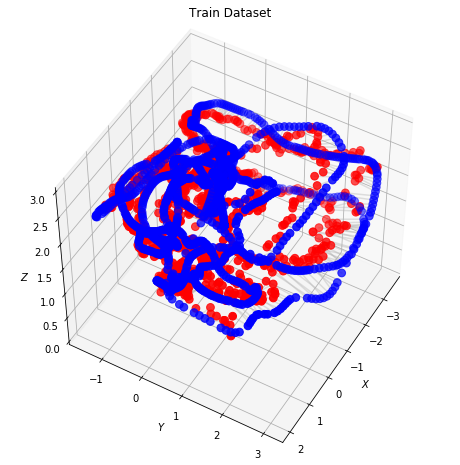

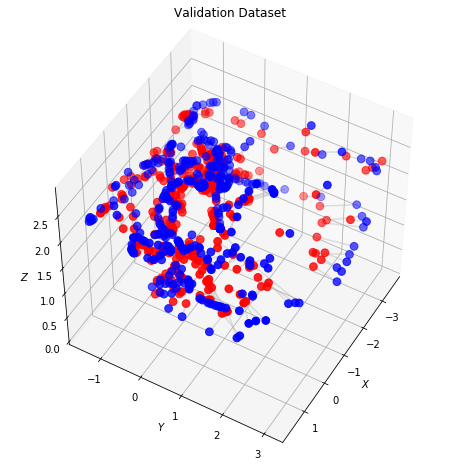

In [56]:
def calc_poses_params(poses, pose_format='full-mat'):
    """Calculates min, max, mean and std of translations of the poses"""

    p = poses[0]
    allp = extract_translation(p, pose_format)

    for p in poses[1:]:
        allp = np.vstack((allp, extract_translation(p, pose_format)))

    p_min = np.min(allp, axis=0)
    p_max = np.max(allp, axis=0)
    p_mean = np.mean(allp, axis=0)
    p_std = np.std(allp, axis=0)

    return p_min, p_max, p_mean, p_std

def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def extract_translation(p, pose_format='full-mat'):
    if pose_format == 'full-mat':
        return p[0:3, 3]
    elif pose_format == 'quat':
        return p[:3]
    else:
        warnings.warn("pose_format should be either 'full-mat' or 'quat'")
        return p


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()
    
def draw_poses(ax, poses, c='b', s=20, proj=False, proj_z=0, pose_format='quat'):
    """Draws the list of poses.
    Args:
        ax (Axes3D): 3D axes
        poses (list): Poses list
        c: matplotlib color
        s: matplotlib size
        proj (bool): True if draw projection of a path on z-axis
        proj_z (float): Coord for z-projection
    """
    coords = np.zeros((len(poses), 3))
    for i, p in enumerate(poses):
        # coords[i] = p[:3, 3]
        # coords[i] = p
        coords[i] = extract_translation(p, pose_format=pose_format)

    # Draw projection
    if proj:
        if len(poses) > 1:
            ax.plot(coords[:, 0], coords[:, 1], proj_z, c='g')
        elif len(poses) == 1:
            ax.scatter(coords[:, 0], coords[:, 1], proj_z, c=c)

    # Draw path
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=c, s=s)


def draw_poses_list(ax, poses_list):
    """Draw list of lists of poses."""
    for poses in poses_list:
        draw_poses(ax, poses)

# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('Validation Dataset')
plt.show()

In [58]:
def save_checkpoint(model, optimizer, criterion, experiment_name='test', epoch=None,
                    time_str=None):
    if not time_str:
        time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    fname = '{}_{}'.format(time_str, experiment_name)
    if epoch is not None:
        fname += '_e{:03d}'.format(epoch)
    fname += '.pth.tar'

    checkpoints_dir = '_checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    fname_path = os.path.join(checkpoints_dir, fname)

    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict()
    }
    
    if criterion.learn_beta:
        checkpoint_dict.update({'criterion_state_dict': criterion.state_dict()})

    torch.save(checkpoint_dict, fname_path)

    return fname_path



In [67]:
experiment_name = 'IMU_Camera'

In [68]:
#  Save checkpoint
save_checkpoint(model, optimizer, criterion, 'nb_{}'.format(experiment_name), n_epochs)

'_checkpoints/20190509_000928_nb_IMU_Camera_e2000.pth.tar'

In [64]:
training_losses=[]
for i in range(len(train_loss)):
    training_losses.append(train_loss[i].val.cpu().clone().numpy())

validation_losses=[]
for i in range(len(test_loss)):   
    validation_losses.append(test_loss[i].val.cpu().clone().numpy())





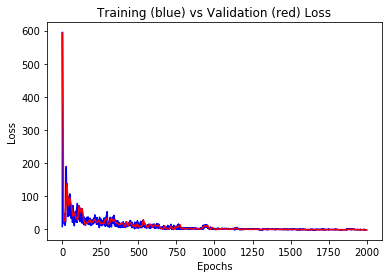

In [66]:
import matplotlib.pyplot as plt

plt.title('Training (blue) vs Validation (red) Loss')
plt.plot(training_losses, '-b', label='trainin loss')
x = np.linspace(0, 2000, len(validation_losses), endpoint=True)
plt.plot(x, validation_losses, '-r', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()